In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

os.chdir("/home/krrish/home/desktop/sensor-behaviour/")

In [12]:
data = pd.read_csv("data/train.csv")

# Dataset Feature Description

| Feature            | Description                                                                                                         | Notes                       |
|--------------------|---------------------------------------------------------------------------------------------------------------------|-----------------------------|
| **row_id**         | Unique identifier for each row in the dataset                                                                      |                             |
| **sequence_id**    | ID for each batch of sensor data; each sequence contains one Transition, one Pause, and one Gesture                 | Grouping unit               |
| **sequence_type**  | Indicates if the gesture is a *target* or *non-target* type                                                         | Training data only          |
| **sequence_counter** | Counter for the row position within each sequence                                                                  | Sequence-level ordering     |
| **subject**        | Unique ID for the subject who provided the data                                                                     |                             |
| **gesture**        | Target variable describing the performed gesture                                                                    | Training data only, target  |
| **orientation**    | Subject's orientation during the sequence                                                                            | Training data only          |
| **behavior**       | Subject's behavior description during the current phase                                                             |                             |

---

### Sensor Data

| Feature          | Description                                                                                                         | Units/Details               |
|------------------|---------------------------------------------------------------------------------------------------------------------|----------------------------|
| **acc_[x/y/z]**  | Linear acceleration along x, y, z axes from IMU sensor                                                              | meters per second squared   |
| **rot_[w/x/y/z]**| Orientation data from IMU combining gyroscope, accelerometer, magnetometer readings to describe 3D orientation       | Quaternion format           |
| **thm_[1-5]**    | Temperature readings from 5 thermopile sensors on the watch                                                          | Degrees Celsius             |
| **tof_[1-5]_v[0-63]** | Distance measurements from 5 time-of-flight sensors; each sensor has 64 pixels in an 8x8 grid                     | Sensor values (0-254), -1 means no signal |

---

### Notes:
- **gesture** is the **target column** for prediction.
- **sequence_id** groups sensor readings into meaningful units (Transition, Pause, Gesture).
- Time-of-flight sensor pixels (tof) represent spatial distance data arranged row-wise (8x8).


In [ ]:
data["gesture"].value_counts() # signs that data is imbalanced

gesture
Text on phone                                 58462
Neck - scratch                                56619
Eyebrow - pull hair                           44305
Forehead - scratch                            40923
Forehead - pull hairline                      40802
Above ear - pull hair                         40560
Neck - pinch skin                             40507
Eyelash - pull hair                           40218
Cheek - pinch skin                            40124
Wave hello                                    34356
Write name in air                             31267
Pull air toward your face                     30743
Feel around in tray and pull out an object    17114
Glasses on/off                                13542
Drink from bottle/cup                         13093
Scratch knee/leg skin                         12328
Write name on leg                             10138
Pinch knee/leg skin                            9844
Name: count, dtype: int64

In [17]:
data[["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]] # 5 Temperature sensors

,thm_1,thm_2,thm_3,thm_4,thm_5
0,28.943842,31.822186,29.553024,28.592863,28.310535
1,29.340816,31.874645,29.791740,28.663383,28.406172
2,30.339359,30.935045,30.090014,28.796087,28.529778
3,30.543730,27.044001,29.310717,29.018711,27.402010
4,29.317265,25.270855,26.808746,29.408604,27.357603
...,...,...,...,...,...
574940,29.329695,27.966221,27.857061,30.359417,29.501087
574941,29.370110,28.101042,27.965866,30.417227,29.244358
574942,29.458855,28.060148,27.893045,30.340141,29.244358
574943,29.789215,28.434057,28.046608,30.397961,28.868093


In [84]:
data["sequence_id"].value_counts() # Sequence IDs

sequence_id
SEQ_015261    700
SEQ_014205    671
SEQ_028188    647
SEQ_060593    630
SEQ_016031    567
             ... 
SEQ_011271     34
SEQ_032114     34
SEQ_022667     34
SEQ_059162     34
SEQ_009199     29
Name: count, Length: 8151, dtype: int64

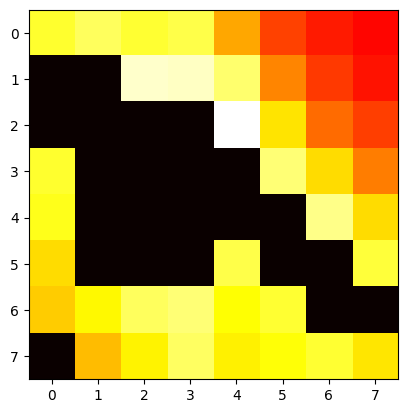

array([[130., 138., 131., 135., 101.,  76.,  66.,  61.],
       [ -1.,  -1., 156., 155., 141.,  93.,  74.,  64.],
       [ -1.,  -1.,  -1.,  -1., 165., 116.,  86.,  75.],
       [130.,  -1.,  -1.,  -1.,  -1., 142., 114.,  91.],
       [127.,  -1.,  -1.,  -1.,  -1.,  -1., 145., 114.],
       [114.,  -1.,  -1.,  -1., 135.,  -1.,  -1., 132.],
       [110., 121., 138., 142., 123., 131.,  -1.,  -1.],
       [ -1., 106., 120., 139., 119., 124., 131., 117.]])

In [88]:
grid = data.loc[1, f"tof_1_v0" : "tof_1_v63"].values.reshape(8, 8).astype(float)
plt.imshow(grid, cmap='hot', interpolation="nearest")
plt.show()
grid

In [63]:
data.loc[4, "thm_1" : "thm_5"]  # Temperature sensors for the first row

thm_1    29.317265
thm_2    25.270855
thm_3    26.808746
thm_4    29.408604
thm_5    27.357603
Name: 4, dtype: object